In [85]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 


# Read the data from the csv file
ratings = pd.read_csv('clean_data/books_rating_clean.csv')
books = pd.read_csv('clean_data/books_data_clean.csv')

In [87]:
# get 100 most popular books
n_books= 20
popular_books = ratings['title'].value_counts()[0:20].index.tolist()

#popular_books = ratings['title'].sample(n_books).value_counts().index.tolist()

# keep only the popular books
popular_books_data = books[books['title'].isin(popular_books)]
popular_books_data = popular_books_data[popular_books_data['description'].notna()]
popular_books_data.reset_index(drop=True, inplace=True)


# get the ratings of the popular books
popular_books_ratings = ratings[ratings['title'].isin(popular_books_data['title'].tolist())]

# reset the index
popular_books_ratings.reset_index(drop=True, inplace=True)


# Recommendations using network-based algorithms

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = popular_books_data['description']
vector = TfidfVectorizer(max_df=0.3,         # drop words that occur in more than X percent of documents
                        min_df=1,      # only use words that appear at least X times
                        stop_words='english', # remove stop words
                        lowercase=True, # Convert everything to lower case 
                        use_idf=True,   # Use idf
                        norm=u'l2',     # Normalization
                        smooth_idf=True # Prevents divide-by-zero errors
                        )

tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 3
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names_out()

#print the centers of the clusters
for i in range(0,k):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:10]:
        word_list.append(terms[j])
    print(word_list) 

request_transform = vector.transform(popular_books_data['description'])
cluster_asign = kmeans.predict(request_transform)

# new column cluster based on the description
popular_books_data['cluster'] = kmeans.predict(request_transform) 

popular_books_data['cluster'].value_counts().head()

cluster0:
['picture', 'dorian', 'oscar', 'gray', 'wilde', 'man', 'pride', 'work', 'family', 'maxnotes']
cluster1:
['dickens', 'life', 'pip', 'expectations', 'penguin', 'novel', 'great', 'generosity', 'ward', 'mysterious']
cluster2:
['van', 'het', 'en', 'op', 'een', 'zich', 'uit', 'homerus', 'jaar', 'waarbij']


c:\Users\Lenovo\OneDrive - Danmarks Tekniske Universitet\9. semester\CompTool\comptool\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


cluster
0    12
2     2
1     1
Name: count, dtype: int64

In [92]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

In [93]:
popular_books_data.columns

Index(['Unnamed: 0', 'title', 'description', 'authors', 'published_date',
       'categories', 'n_ratings', 'avg_rating', 'cluster'],
      dtype='object')

In [94]:
G = nx.Graph()
start_time = time.time()
for i, rowi in popular_books_data.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    # add nodes for the book
    G.add_node(rowi['title'], key=rowi['title'], label="BOOK", rating=rowi['avg_rating'])

    # add nodes for the authors and connect them to the book
    G.add_node(rowi['authors'],label="authors")
    G.add_edge(rowi['title'], rowi['authors'])
    
    # add categories and connect them to the book
    G.add_node(rowi['categories'],label="categories")
    G.add_edge(rowi['categories'], rowi['title'])
    G.add_edge(rowi['categories'], rowi['authors'])
    try:
        indices = find_similar(tfidf, i, top_n = 5)
    except:
        continue
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    #G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, popular_books_data['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))  

 iter 0 -- 0.0030062198638916016 seconds --
 finish -- 0.03051018714904785 seconds --


In [95]:
# extract largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

# base node size on avg_rating attribute
sizes = []

# generate a list of colors for the nodes
colors = []
print(len(G0.nodes))
label_vec = {}
for node in G0:
    if G0.nodes[node]['label'] == "BOOK":
        sizes.append(10*G0.nodes[node]['rating'])
        colors.append('red')
        label_vec[node] = node
    elif G0.nodes[node]['label'] == "authors":
        sizes.append(10)
        colors.append('green')
    else:
        sizes.append(10)
        colors.append('blue')

print(len(colors))
print(len(sizes))
print((label_vec))

47
47
47
{'of mice and men': 'of mice and men', 'sense and sensibility': 'sense and sensibility', 'to kill a mockingbird': 'to kill a mockingbird', 'brave new world': 'brave new world', 'great expectations': 'great expectations', 'little women or meg jo beth and amy': 'little women or meg jo beth and amy', 'the hobbit': 'the hobbit', 'the great gatsby': 'the great gatsby', 'emma': 'emma', 'pride and prejudice': 'pride and prejudice', 'ulysses': 'ulysses', 'little women': 'little women', 'persuasion': 'persuasion', 'the picture of dorian gray': 'the picture of dorian gray'}


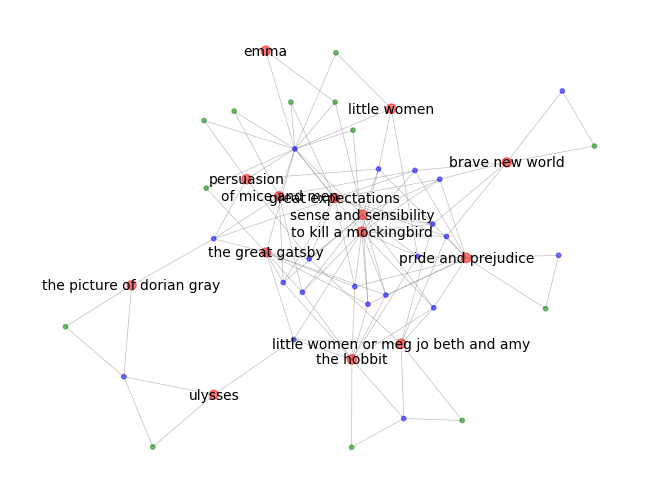

<Figure size 640x480 with 0 Axes>

In [103]:
# draw the graph
nx.draw(G0,pos = nx.kamada_kawai_layout(G0), node_size= sizes, node_color = colors, with_labels=False, alpha=0.5, width=0.5, edge_color='grey')
nx.draw_networkx_labels(G0,pos=nx.kamada_kawai_layout(G0),labels=label_vec,font_size=10,font_color='black')
plt.show()
plt.savefig('figs/graph.pdf')

In [97]:
# print nodes with the highest degree
print("Highest degree nodes:")
print(sorted(G0.degree, key=lambda x: x[1], reverse=True)[:10])


Highest degree nodes:
[("['Fiction']", 15), ('to kill a mockingbird', 14), ('sense and sensibility', 12), ('pride and prejudice', 11), ('great expectations', 10), ('the hobbit', 10), ('the great gatsby', 10), ('little women or meg jo beth and amy', 7), ('of mice and men', 6), ('brave new world', 6)]


In [98]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="BOOK":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    books=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        books.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=books)
    result.sort_values(inplace=True,ascending=False)        
    return result

In [99]:
title = "the hobbit"
result = get_recommendation(title)
print("-"*60 +"\n Recommendation for " + title  + "\n"+"-"*60)
print(result.head())

------------------------------------------------------------
 Recommendation for the hobbit
------------------------------------------------------------
to kill a mockingbird                  4.349345
sense and sensibility                  3.728010
the great gatsby                       3.728010
pride and prejudice                    3.106675
little women or meg jo beth and amy    1.964017
dtype: float64


In [100]:
title = popular_books_ratings['title'].unique().tolist()[4]
result = get_recommendation(title)
print("-"*60 +"\n Recommendation for " + title  + "\n"+"-"*60)
print(result.head())

------------------------------------------------------------
 Recommendation for great expectations
------------------------------------------------------------
to kill a mockingbird    3.475944
the great gatsby         2.854609
sense and sensibility    2.854609
brave new world          2.485340
pride and prejudice      2.485340
dtype: float64


In [101]:
# for user obtain the top 5 books based on what he/she has read
import random

# pick a random user
user = popular_books_ratings['user_id'].iloc[9]
# get the books that the user has read
user_books = popular_books_ratings[popular_books_ratings['user_id'] == user][['title','score']]

# remove duplicate titles
user_books.drop_duplicates(subset=['title'], inplace=True)

# extract titles
user_titles = user_books['title'].unique().tolist()

# get the books that the user has not read
user_unread_books = popular_books_data[~popular_books_data['title'].isin(user_titles)]['title'].unique()

# get recommendations for the user
recommendations = pd.DataFrame(columns=['title', 'score'])
for book in user_titles:
    rec = get_recommendation(book)
    title = rec.index.tolist()
    for t in title:
        if t not in user_unread_books and t not in recommendations['title'].tolist():
            print(t)
            val = rec.values.tolist()
            new_rec = pd.DataFrame({'title': title, 'score': val})
            recommendations = pd.concat([recommendations, new_rec], ignore_index=True)


# sort the recommendations
recommendations.sort_values(by='score',inplace=True,ascending=False)
recommendations.reset_index(drop=True, inplace=True)

print(recommendations.head(10))
# print the top 5 recommendations
#print(recommendations.head())


the great gatsby
of mice and men
                   title     score
0             the hobbit  3.728010
1  to kill a mockingbird  3.475944
2  sense and sensibility  3.475944
3     great expectations  2.854609
4       the great gatsby  2.233274
5     great expectations  2.233274
6        of mice and men  2.233274
7    pride and prejudice  1.864005
8  sense and sensibility  1.611939
9  to kill a mockingbird  1.611939


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16168\1779955630.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recommendations = pd.concat([recommendations, new_rec], ignore_index=True)
